### Insight Follow Ups

New Follow Up as of 8/2/2019

Student version of charts 


Original Follow Up

- Could we do what % of districts not meeting would reach 1 Mbps with a 100%, 200%, 300%, 400% increase, cumulative? 
- For example, if everyone went up 500%, what would happen? 

In [1]:
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

sql_query = """
select 
    d.district_id,
    d.funding_year,
    d.district_type,
    d.in_universe,
    dffa.fit_for_ia,
    d.num_students,
    dbw.ia_bw_mbps_total,
    dbw.projected_bw_fy2018,
    dbw.projected_bw_fy2018_cck12,
    dbw.meeting_2018_goal_oversub

-- basic district info
FROM ps.districts d

-- district costs and bw
JOIN ps.districts_bw_cost dbw
ON d.district_id = dbw.district_id
AND d.funding_year = dbw.funding_year

-- to check for fit for ia
JOIN ps.districts_fit_for_analysis dffa
ON d.district_id = dffa.district_id
AND d.funding_year = dffa.funding_year

where d.funding_year = 2019
"""

#query data
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [4]:
df.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub
0,881421,2019,Traditional,True,True,5687,2000,4833.95,5000,False
1,881422,2019,Traditional,True,True,194,1000,194,200,True
2,881423,2019,Traditional,True,True,1319,2000,1319,2000,True
3,881424,2019,Traditional,True,True,5387,1000,4578.95,5000,False
4,881427,2019,Traditional,True,True,13938,10000,9756.6,10000,True


### Masks/filters

In [5]:
mask_not_meeting = df.meeting_2018_goal_oversub == False
mask_meeting = df.meeting_2018_goal_oversub == True
mask_traditional = df.district_type == 'Traditional'
mask_fit_ia = df.fit_for_ia == True
mask_in_universe = df.in_universe == True

### Convert Decimal to Float

In [6]:
numeric_cols = ['num_students', 'ia_bw_mbps_total','projected_bw_fy2018']
df[numeric_cols] = df[numeric_cols].astype(float)

### Extrapolation

In [7]:
num_population_districts = df[mask_in_universe & mask_traditional].district_id.nunique()
num_sample_districts = df[mask_fit_ia &
                          mask_in_universe &
                          mask_traditional].district_id.nunique()

print(f"Number of population districts: {num_population_districts}")
print(f"Number of sample districts: {num_sample_districts}")

Number of population districts: 12912
Number of sample districts: 12648


In [33]:
num_population_students = df[mask_in_universe & mask_traditional].num_students.sum()
num_sample_students = df[mask_fit_ia &
                          mask_in_universe &
                          mask_traditional].num_students.sum()

print(f"Number of population students: {num_population_students}")
print(f"Number of sample students: {num_sample_students}")

Number of population students: 47059753.0
Number of sample students: 46524313.0


In [8]:
# districts clean and not meeting 1 mbps
df_clean = df[mask_not_meeting & 
                mask_traditional & 
                mask_fit_ia & 
                mask_in_universe]

In [9]:
df_clean.shape

(7914, 10)

In [10]:
df_clean.district_id.nunique()

7914

### Calculating pct_bw_increase_to_meet_1Mbps

In [12]:
df_clean.loc[:, 'pct_bw_increase_to_meet_1Mbps'] = ((df_clean.loc[:, 'projected_bw_fy2018'] - df_clean.loc[: ,'ia_bw_mbps_total'])/df_clean.loc[:, 'ia_bw_mbps_total'])*100

In [13]:
df_clean.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub,pct_bw_increase_to_meet_1Mbps
0,881421,2019,Traditional,True,True,5687.0,2000.0,4833.95,5000,False,141.697500
3,881424,2019,Traditional,True,True,5387.0,1000.0,4578.95,5000,False,357.895000
5,881428,2019,Traditional,True,True,2297.0,1000.0,2297.00,3000,False,129.700000
6,881431,2019,Traditional,True,True,10440.0,7500.0,8874.00,10000,False,18.320000
7,881433,2019,Traditional,True,True,3858.0,1650.0,3279.30,3000,False,98.745455


### Place `pct_bw_increase_to_meet_1Mbps` into bins for plotting

In [15]:
# indicate bins for categories
max_bin = 3100
increment = 100
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_clean.loc[:,'bw_pct_change_category'] = pd.cut(df_clean['pct_bw_increase_to_meet_1Mbps'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_clean.loc[:, 'bw_pct_change_category'] = df_clean['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_clean[['bw_pct_change_category']] = df_clean[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_clean.loc[:, 'bw_pct_change_category'] = df_clean['bw_pct_change_category'].astype(str)

In [34]:
# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_clean.bw_pct_change_category.value_counts().to_frame()

# add student counts
df_pct_change = pd.merge(df_pct_change, 
                         pd.DataFrame(df_clean.groupby('bw_pct_change_category')['num_students'].sum()),
                         left_index=True,
                         right_index=True)

# merge into resultant dataframe to keep order of index
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count', 'num_students']

# add extrapolated numbers
df_pct_change['district_count_extrapolated'] = (df_pct_change['district_count']*num_population_districts)/(num_sample_districts)

# add extrapolated numbers for student counts
df_pct_change['num_students_extrapolated'] = (df_pct_change['num_students']*num_population_students)/(num_sample_students)

In [35]:
df_pct_change

,pct_category,district_count,num_students,district_count_extrapolated,num_students_extrapolated
0,less than 100%,3329,12265451.0,3398.485769,1.240661e+07
1,100%,1995,9150618.0,2036.641366,9.255931e+06
2,200%,1088,6345907.0,1110.709677,6.418941e+06
3,300%,638,3825087.0,651.316888,3.869109e+06
4,400%,347,4137055.0,354.242884,4.184668e+06
5,500%,211,1156026.0,215.404175,1.169330e+06
6,600%,118,679342.0,120.462998,6.871604e+05
7,700%,74,316835.0,75.544592,3.204814e+05
8,800%,43,123295.0,43.897533,1.247140e+05
9,900%,16,72465.0,16.333966,7.329899e+04


### Adding cumulative counts

In [36]:
# cumulative sum (sample)
df_pct_change.loc[:, 'district_count_cumsum'] = df_pct_change['district_count'].cumsum(axis = 0) 

# cumulative sum (extrapolated)
df_pct_change.loc[:, 'district_count_extrapolated_cumsum'] = df_pct_change['district_count_extrapolated'].cumsum(axis = 0) 

# percentage by pct_category - cumulative(sample)
df_pct_change.loc[:, 'district_count_cumsum_pct'] = df_pct_change.loc[:, 'district_count_cumsum']/df_pct_change.district_count.sum()

# percentage by pct_category - cumulative(extrapolated)
df_pct_change.loc[:, 'district_count_extrapolated_cumsum_pct'] = df_pct_change.loc[:, 'district_count_extrapolated_cumsum']/df_pct_change.district_count_extrapolated.sum()

# percentage by pct_category (sample)
df_pct_change.loc[:, 'district_count_pct'] = df_pct_change.loc[:, 'district_count']/df_pct_change.district_count.sum()

In [86]:
# cumulative student counts (sample)
df_pct_change.loc[:, 'num_students_cumsum'] = df_pct_change['num_students'].cumsum(axis = 0) 

# cumulative sum (extrapolated)
df_pct_change.loc[:, 'num_students_extrapolated_cumsum'] = df_pct_change['num_students_extrapolated'].cumsum(axis = 0)

# percentage by pct_category - cumulative(sample)
df_pct_change.loc[:, 'num_students_cumsum_pct'] = df_pct_change.loc[:, 'num_students_cumsum']/df_pct_change.num_students.sum()

# percentage by pct_category - cumulative(extrapolated)
df_pct_change.loc[:, 'num_students_extrapolated_cumsum_pct'] = df_pct_change.loc[:, 'num_students_extrapolated_cumsum']/df_pct_change.num_students_extrapolated.sum()

# percentage by pct_category (sample)
df_pct_change.loc[:, 'num_students_pct'] = df_pct_change.loc[:, 'num_students']/df_pct_change.num_students.sum()

# pretty print of 'num_students_cumsum'
df_pct_change.loc[:, 'num_students_cumsum_pp'] = (df_pct_change.loc[:, 'num_students_cumsum']/1000000).apply(lambda x: '{:,.1f}M'.format(x))

# pretty print of 'num_students'
df_pct_change.loc[:, 'num_students_pp'] = (df_pct_change.loc[:, 'num_students']/1000000).apply(lambda x: '{:,.1f}M'.format(x))



In [87]:
df_pct_change

,pct_category,district_count,num_students,district_count_extrapolated,num_students_extrapolated,district_count_cumsum,district_count_extrapolated_cumsum,district_count_cumsum_pct,district_count_extrapolated_cumsum_pct,district_count_pct,num_students_cumsum,num_students_extrapolated_cumsum,num_students_cumsum_pct,num_students_extrapolated_cumsum_pct,num_students_pct,num_students_cumsum_pp,num_students_pp
0,less than 100%,3329,12265451.0,3398.485769,1.240661e+07,3329,3398.485769,0.420647,0.420647,0.420647,12265451.0,1.240661e+07,0.320144,0.320144,0.320144,12.3M,12.3M
1,100%,1995,9150618.0,2036.641366,9.255931e+06,5324,5435.127135,0.672732,0.672732,0.252085,21416069.0,2.166254e+07,0.558986,0.558986,0.238843,21.4M,9.2M
2,200%,1088,6345907.0,1110.709677,6.418941e+06,6412,6545.836812,0.810210,0.810210,0.137478,27761976.0,2.808148e+07,0.724623,0.724623,0.165636,27.8M,6.3M
3,300%,638,3825087.0,651.316888,3.869109e+06,7050,7197.153700,0.890826,0.890826,0.080617,31587063.0,3.195059e+07,0.824462,0.824462,0.099840,31.6M,3.8M
4,400%,347,4137055.0,354.242884,4.184668e+06,7397,7551.396584,0.934673,0.934673,0.043846,35724118.0,3.613526e+07,0.932444,0.932444,0.107982,35.7M,4.1M
5,500%,211,1156026.0,215.404175,1.169330e+06,7608,7766.800759,0.961334,0.961334,0.026662,36880144.0,3.730459e+07,0.962618,0.962618,0.030174,36.9M,1.2M
6,600%,118,679342.0,120.462998,6.871604e+05,7726,7887.263757,0.976245,0.976245,0.014910,37559486.0,3.799175e+07,0.980350,0.980350,0.017732,37.6M,0.7M
7,700%,74,316835.0,75.544592,3.204814e+05,7800,7962.808349,0.985595,0.985595,0.009351,37876321.0,3.831223e+07,0.988620,0.988620,0.008270,37.9M,0.3M
8,800%,43,123295.0,43.897533,1.247140e+05,7843,8006.705882,0.991029,0.991029,0.005433,37999616.0,3.843695e+07,0.991838,0.991838,0.003218,38.0M,0.1M
9,900%,16,72465.0,16.333966,7.329899e+04,7859,8023.039848,0.993050,0.993050,0.002022,38072081.0,3.851025e+07,0.993729,0.993729,0.001891,38.1M,0.1M


### Plotting cumulative districts/pct by pct_bw_increase - District

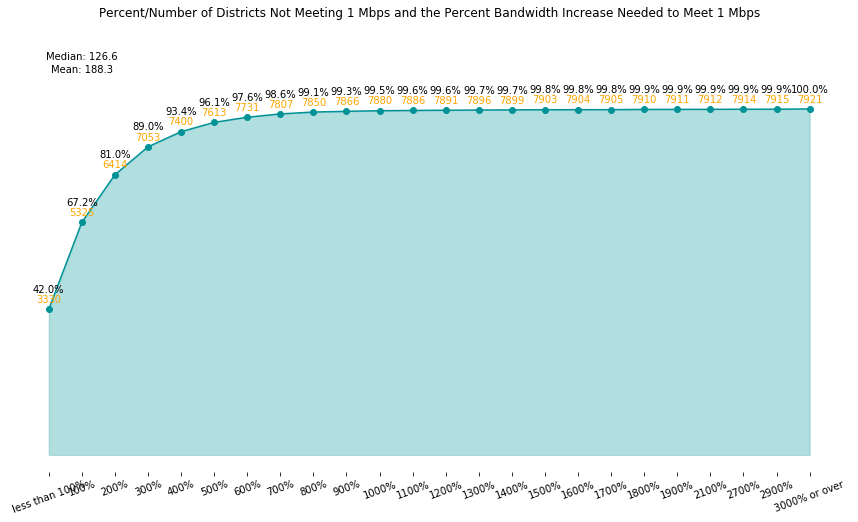

In [31]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.plot(xmarks, df_pct_change['district_count_cumsum'], color='#009296', marker='o')
plt.fill_between(xmarks,df_pct_change['district_count_cumsum'], color='#009296', alpha=0.3)

# ticks, titles, axis labels
# plt.ylabel("Percent/Number of Districts Not Meeting 1 Mbps")
plt.title("Percent/Number of Districts Not Meeting 1 Mbps and the Percent Bandwidth Increase Needed to Meet 1 Mbps", y=1.18)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count_cumsum'], 
                         df_pct_change['district_count_cumsum'],
                         df_pct_change['district_count_cumsum_pct']
                        ):
    plt.text(x0, v0+100, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+330, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(1, 9000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
plt.text(1, 8700, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("pct_bw_increase_districts_not_meeting_cumulative_073119.png", bbox_inches = 'tight')



### Cumulative Plot - Student Version

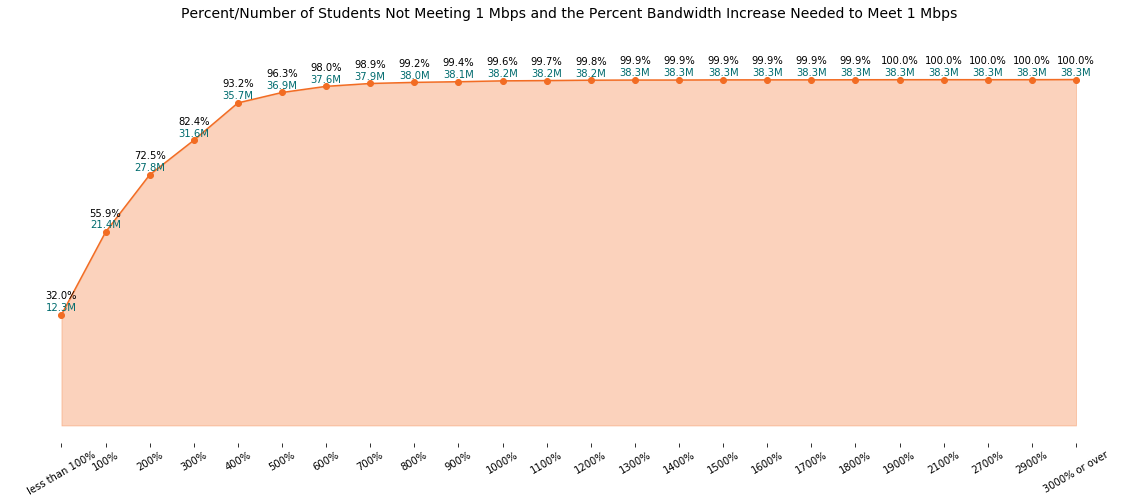

In [84]:
# plotting the figure
plt.figure(figsize=(20, 7))
xmarks = np.arange(0, df_pct_change.shape[0])

col_to_plot = 'num_students_cumsum'
plt.plot(xmarks, df_pct_change[col_to_plot], color='#f26c23', marker='o')
plt.fill_between(xmarks,df_pct_change[col_to_plot], color='#f26c23', alpha=0.3)

# ticks, titles, axis labels
# plt.ylabel("Percent/Number of Districts Not Meeting 1 Mbps")
plt.title("Percent/Number of Students Not Meeting 1 Mbps and the Percent Bandwidth Increase Needed to Meet 1 Mbps", y=1.1, fontsize=14)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=30)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change[col_to_plot], 
                         df_pct_change[col_to_plot+'_pp'],
                         df_pct_change[col_to_plot+'_pct']
                        ):
    plt.text(x0, v0+180000, label, ha='center', va='bottom', color='#006b6e')
    plt.text(x0, v0+1500000, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
# plt.text(1, 9000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
# plt.text(1, 8700, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("pct_bw_increase_districts_not_meeting_cumulative_students_080219.png", bbox_inches = 'tight')



### Plotting by pct_category (not cumulative)

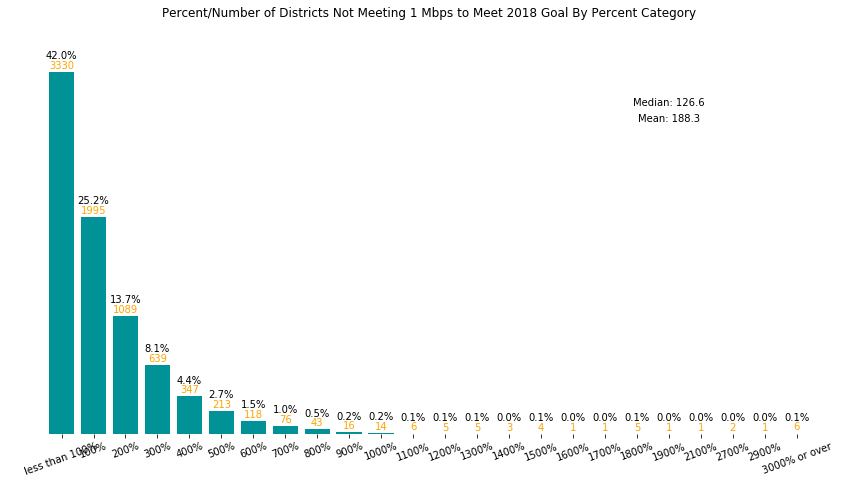

In [34]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['district_count'], color='#009296')

# ticks, titles, axis labels
plt.title("Percent/Number of Districts Not Meeting 1 Mbps to Meet 2018 Goal By Percent Category", y=1.08)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count'], 
                         df_pct_change['district_count'],
                         df_pct_change['district_count_pct']
                        ):
    plt.text(x0, v0+10, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+100, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(19, 3000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
plt.text(19, 2850, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
# plt.savefig("pct_bw_increase_districts_not_meeting_students_080219.png", bbox_inches = 'tight')


### Student Version (not cumulative)

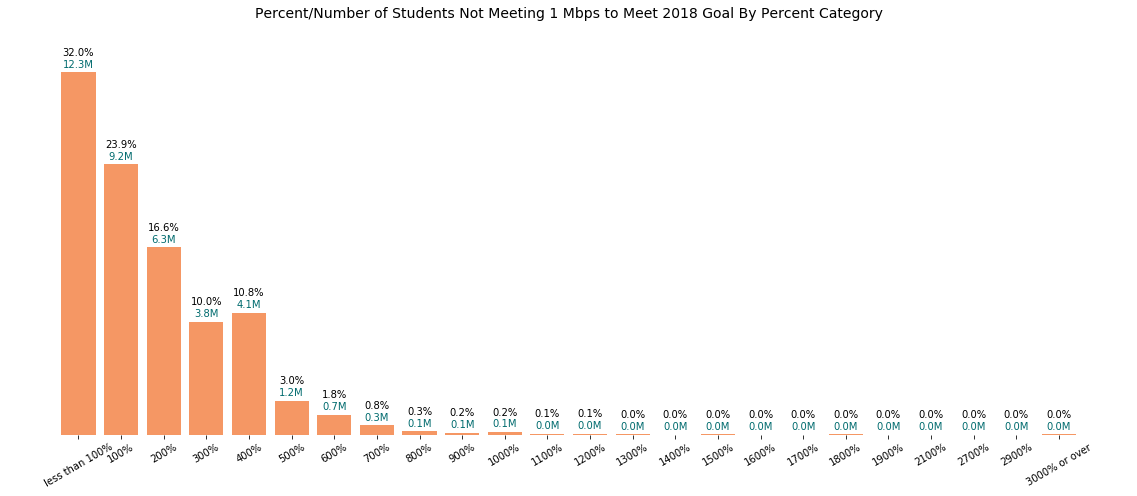

In [106]:
# plotting the figure
plt.figure(figsize=(20, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['num_students'], color='#f26c23', alpha=0.7)

# ticks, titles, axis labels
plt.title("Percent/Number of Students Not Meeting 1 Mbps to Meet 2018 Goal By Percent Category", y=1.08, fontsize=14)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=30)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['num_students'], 
                         df_pct_change['num_students_pp'],
                         df_pct_change['num_students_pct']
                        ):
    plt.text(x0, v0+100000, label, ha='center', va='bottom', color='#006b6e')
    plt.text(x0, v0+500000, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
#plt.text(19, 3000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
#plt.text(19, 2850, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("pct_bw_increase_districts_not_meeting_students_080219.png", bbox_inches = 'tight')

In [1]:
# convert jupyter notebook to .py
!jupyter nbconvert --to script districts_not_meeting_by_pct_bw_incease_student.ipynb

[NbConvertApp] Converting notebook districts_not_meeting_by_pct_bw_incease_student.ipynb to script
[NbConvertApp] Writing 13633 bytes to districts_not_meeting_by_pct_bw_incease_student.py
